In [1]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
def show_img(img):
    fig = plt.figure(figsize=(18, 16), dpi = 80, facecolor='w', edgecolor='k')
    plt.imshow(img)

In [3]:
def blur_img(img, blur_level):
    h, w = img.shape
    rw, rh = math.floor(w/blur_level), math.floor(h/blur_level)
    img_resized = cv.resize(img, (rw, rh))
    img_blured = cv.resize(img_resized, (w, h))
    return img_blured

In [4]:
def sub_img(img, wsub, hsub):
    blur_pieces = []
    h, w = img.shape
    wsubsize, hsubsize = math.floor(w/wsub), math.floor(h/hsub)
    for i in range(hsub-1):
        for j in range(wsub-1):
            blur_pieces.append(img[hsubsize*i:hsubsize*(i+1), wsubsize*j:wsubsize*(j+1)])
    return blur_pieces

In [5]:
def to_binary(img):
    thresh, im = cv.threshold(img, 170,255, cv.THRESH_BINARY );
    return im

### Load Data

In [6]:

import glob

training_path = './data/Book/'
training_data = []
img_set, blur_set = [], []
for filename in glob.glob(training_path+'/*.jpg'):
    im = cv.imread(filename, 0)
    w, h = im.shape
    im = cv.resize(im, (math.floor(h/3), math.floor(w/3)))
    im = sub_img(im, 9*6, 12*6)
    img_set += [x / 255 for x in im]
random.shuffle(img_set)

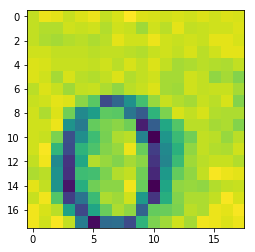

In [14]:
%matplotlib inline
pick_random = random.randrange(len(img_set))
# print(img_set[pick_random])
plt.imshow(img_set[pick_random])

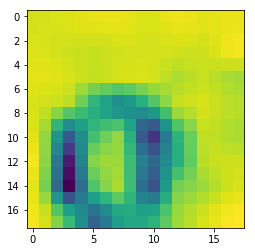

In [15]:
test = blur_img(img_set[pick_random], blur_level=1.5+random.random())
plt.imshow(test)

In [16]:
print('Number of images:', len(img_set), 'Size:', img_set[0].shape)

Number of images: 150520 Size: (18, 18)


### Building Model

Placeholders

In [17]:
IMGSIZE = img_set[0].shape[0]
COLOR_CHANNELS = 1
print(IMGSIZE)
data_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
output_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
learning_rate = tf.placeholder('float', [], name = 'learning_rate_ph')

18


In [18]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 1.1)
    return tf.Variable(init_random_dist)

In [19]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [20]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [21]:
def deconvolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(tf.nn.conv2d_transpose(input_x, W, shape, strides = [1,1,1,1], padding='SAME')+b)

In [22]:
def  convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

Layers

In [88]:
hl1 = tf.reshape(data_ph, [-1, IMGSIZE, IMGSIZE, 1])
hl2 = convolutional_layer(hl1, [1, 1, 1, 12])
hl3 = convolutional_layer(hl2, [3, 3, 12, 12])
hl4 = convolutional_layer(hl3, [3, 3, 12, 12])
hl5 = convolutional_layer(hl4, [1, 1, 12, 1])
ol = tf.nn.sigmoid(hl5)
ol_residual = tf.reshape(ol, [-1, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
# ol = tf.contrib.layers.fully_connected(ol_residual, IMGSIZE*IMGSIZE*COLOR_CHANNELS, activation_fn=tf.nn.sigmoid)
ol = ol_residual

mean1, var1 = tf.nn.moments(output_ph, axes=[0])
mean2, var2 = tf.nn.moments(ol, axes=[0])
# print(mean.shape)
loss = tf.reduce_mean((ol - output_ph)**2)+(tf.reduce_mean(mean2)-tf.reduce_mean(mean1))**2
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Load Batch

In [89]:
def load_batch(size, blur):
    batch_x, batch_y = [], []
    for _ in range(size):
        rand_val = random.randrange(0, len(img_set))
        if rand_val == pick_random:
            rand_val = rand_val + random.randrange(0, 10)
        if blur:
            batch_x.append(np.array(blur_img(img_set[rand_val], blur_level=1.5+random.random())).ravel())
        else:
            batch_x.append(np.array(img_set[rand_val]).ravel())
        batch_y.append(np.array(img_set[rand_val]).ravel())
    return batch_x, batch_y

Running session

In [90]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

<IPython.core.display.Javascript object>


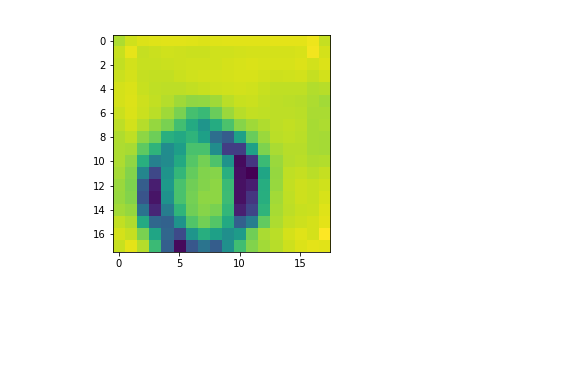

0.049243
0.0487655
0.0425252
0.0420545
0.0144201
0.0147089
0.0098436
0.0101457
0.0116901
0.0124214
0.0151166
0.0214679
0.0137642
0.0176358
0.0107815
0.013753
0.00964921
0.0133064
0.00940458
0.0149222
0.018321
0.0105297
0.00726078
0.0110202
0.00855821
0.0181817
0.0136025
0.0100294
0.0113567
0.0145903
0.0093264
0.0152957
0.0105686
0.00702864
0.0110574
0.0174934
0.0178245
0.0112742
0.012738
0.0141243
0.00927978
0.0118791
0.0122417
0.00962197
0.014769
0.0154757
0.0122878
0.0101664
0.0070522
0.012907
0.0251298
0.0125249
0.0106023
0.0104827
0.00950527
0.0140601
0.0101106
0.00819237
0.0103604
0.00679811
0.00953906
0.00944883
0.0149398
0.0072096
0.00944615
0.0100102
0.0127332
0.0105149
0.00755636
0.0100345
0.00730042
0.0122334
0.00899444
0.0109359
0.0129041
0.0106164
0.00907909
0.0105524
0.0128193
0.011489
0.00921934
0.00602886
0.00788765
0.0107039
0.00711816
0.00636484
0.0102345
0.013675
0.0148843
0.00881996
0.00934085
0.0171166
0.0123188
0.0120558
0.00991498
0.0140774
0.00941886
0.018054
0.0

0.0169224
0.0129901
0.00814093
0.0123079
0.0135589
0.01502
0.010046
0.0107839
0.0129135
0.0112124
0.00886353
0.00882317
0.0151449
0.00689615
0.00676404
0.0114336
0.00755922
0.0175525
0.0123096
0.0101361
0.00911208
0.0102667
0.00873591
0.00633292
0.0168068
0.00918246
0.0120823
0.00889783
0.0153613
0.00776547
0.0191304
0.0101239
0.0104044
0.00818313
0.0144182
0.00982049
0.0102121
0.00785649
0.0150547
0.00832358
0.0137893
0.0109244
0.00876618
0.0151615
0.0143103
0.00598311
0.0151534
0.0149153
0.00623732
0.0098938
0.0106614
0.0119207
0.0120085
0.0115268
0.0109517
0.00804947
0.0123164
0.00902817
0.0102363
0.0115478
0.0122089
0.00974608
0.00924889
0.00732458
0.0115896
0.0102745
0.0102543
0.00882806
0.00962156
0.0101089
0.0140454
0.00649424
0.0109281
0.0104532
0.00894022
0.00966469
0.0126437
0.0138812
0.0119692
0.0120766
0.0173723
0.016011
0.00949894
0.01772
0.0195029
0.0107642
0.00642134
0.0146997
0.00930084
0.0102788
0.010466
0.0149822
0.0114813
0.00815336
0.0124983
0.0144798
0.00946239
0.0

0.00512341
0.0073482
0.013114
0.0160729
0.0141424
0.0075856
0.00982779
0.0159889
0.00425725
0.0126745
0.0130658
0.0183185
0.00632575
0.00988773
0.00628286
0.0173928
0.0138205
0.0129583
0.00827668
0.0185601
0.00851951
0.00983837
0.00645987
0.00762304
0.0140357
0.00905132
0.0124559
0.00777907
0.0153833
0.0106646
0.0151852
0.00791775
0.00481282
0.0102501
0.0118317
0.00900781
0.00739012
0.00957029
0.00715199
0.0138262
0.00880605
0.0154028
0.00757202
0.00934867
0.00863304
0.0108616
0.0115961
0.0108028
0.0119455
0.00993004
0.00562772
0.00733747
0.0101997
0.00788569
0.0128737
0.00958781
0.0141448
0.00747038
0.0128432
0.011456
0.00541939
0.00962965
0.0100497
0.00829605
0.00849148
0.0165191
0.0088873
0.0125145
0.00727271
0.0104682
0.0166653
0.00858701
0.0124019
0.00866143
0.00899915
0.00712931
0.0119174
0.009134
0.00904676
0.0106535
0.00629635
0.00899131
0.00704195
0.00645433
0.00902855
0.0112988
0.00894636
0.0100488
0.0051162
0.0100004
0.0128939
0.00826902
0.0149741
0.00980109
0.0113447
0.0043

0.0101287
0.00628427
0.0142594
0.0158841
0.00868733
0.0108813
0.0180609
0.0147874
0.00583806
0.0167056
0.00800171
0.0134646
0.0124244
0.00883866
0.00618651
0.0222675
0.00928087
0.0122268
0.00859896
0.00696608
0.0157844
0.00845471
0.00686842
0.00611054
0.00581827
0.00910439
0.00948839
0.0105907
0.00799959
0.00967013
0.0136868
0.0219918
0.0132703
0.00933675
0.00804045
0.0154804
0.00591127
0.0107561
0.0107816
0.00722234
0.0155544
0.0111055
0.00812423
0.0137373
0.0174727
0.0107275
0.0218686
0.0180039
0.00967002
0.00692051
0.00952717
0.0124787
0.00860624
0.0168011
0.00951301
0.00667664
0.0176618
0.0139737
0.00914708
0.0182004
0.0114154
0.00937044
0.00847061
0.00841587
0.0106974
0.0141686
0.00850037
0.00777002
0.0126013
0.00986901
0.00779701
0.0129512
0.00604602
0.0115705
0.0174997
0.0156524
0.0162774
0.0123432
0.00822331
0.0084072
0.0110632
0.00732099
0.00826284
0.00968207
0.016166
0.0100133
0.00534427
0.0139479
0.00777612
0.00706908
0.0124472
0.00849695
0.0117097
0.00992983
0.0119579
0.014

KeyboardInterrupt: 

In [103]:
%matplotlib notebook
import time

start = time.time()
batch_size = 50
steps = 550000
rate = 3e-3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size, blur=True)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            last_loss = sess.run(loss, feed_dict = feed)
            print(last_loss)
            if last_loss<0.0055:
                rate = 3e-5
            pred = sess.run(ol, feed_dict={data_ph:[np.array(blur_img(img_set[pick_random], blur_level=2)).ravel()]})
#             pred = sess.run(ol, feed_dict={data_ph:[np.array(img_set[pick_random]).ravel()]})
            ax.clear()
            ax.imshow(np.reshape(pred, [IMGSIZE, IMGSIZE]))
            fig.canvas.draw()

end = time.time()
elapsed = end - start
print(elapsed)

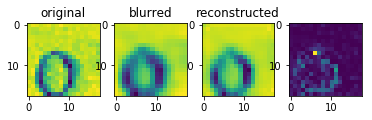

In [109]:
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_set[pick_random])
ax1.set_title('original')
ax2 = fig.add_subplot(1,4,3)
ax2.imshow(np.reshape(pred, [IMGSIZE,IMGSIZE]))
ax2.set_title('reconstructed')
ax3 = fig.add_subplot(1,4,4)
ax3.imshow((img_set[pick_random]-np.reshape(pred, [IMGSIZE,IMGSIZE]))**2)
ax4 = fig.add_subplot(1,4,2)
ax4.imshow(blur_img(img_set[pick_random], blur_level=2))
ax4.set_title('blurred')

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed))

In [21]:
%matplotlib inline
# plt.imshow(np.reshape(pred, [63, 108]))
with tf.Session as sess:
    pred = sess.run(ol, feed_dict={data_ph:[np.array(blur_img(img_set[1], blur_level=3+random.random())).ravel()]})
    plt.imshow(np.reshape(pred, [42, 42]))

AttributeError: __exit__